![image-3.png](https://i.imgur.com/Pfjr0u7.png)

# Training Parameterized Quantum Circuits

Solved by Abdiel Guerrero 💜

In this lab session we will have a closer look on how to train circuit-based models. At the end of this session you should know
* how to build variational quantum classifiers
* how to use different training techniques, especially gradient-based
* what restrictions the variational-based models have and how we might overcome them

## Where do we need to train parameterized circuits?

![](https://i.imgur.com/dCF5rHq.png)

## Our task

![image.png](https://i.imgur.com/JpQv5T4.png)

## Gradients

![](https://i.imgur.com/mqS7f7U.png)

Qiskit provides different methods to compute gradients of expectation values, let's explore them!

The parameterized ansatz state is $|\Psi(\vec\theta)\rangle = U(\vec\theta)|0\rangle$ where $U(\vec\theta)$ is given be the following circuit

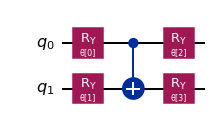

In [2]:
from qiskit.circuit.library import RealAmplitudes

### ANSATZ (𝑈(𝜃⃗)) circuit ###
ansatz = RealAmplitudes(num_qubits=2, reps=1, entanglement='linear')

ansatz.draw('mpl', style='iqx')

and our Hamiltonian in this example is $\hat H = \hat Z \bigotimes \hat Z$

In [3]:
from qiskit.opflow import Z, I

### 𝑍̂ ⨂ 𝑍̂  ###
hamiltonian = Z ^ Z

Plugged together to $\langle\Psi(\vec\theta) | \hat H | \Psi(\vec\theta)\rangle$:

In [4]:
from qiskit.opflow import StateFn

###  ⟨ Ψ(𝜃⃗)|𝐻̂|Ψ(𝜃⃗)  ###
expectation = StateFn(hamiltonian, is_measurement=True) @ StateFn(ansatz)

To make things concrete, let's fix a point $\vec p$ and an index $i$ and ask: What's the derivative of the expectation value with respect to parameter $\theta_i$ at point $\vec p$?

$$
    \frac{\partial}{\partial \theta_i} \langle \Psi(\vec\theta) | \hat H | \Psi(\vec\theta) \rangle \bigg\vert_{\vec\theta = \vec p}
$$

We'll choose a random point $\vec p$ and index $i=2$ (remember we start counting from 0).

In [5]:
import numpy as np

### Random Point ###
point = np.random.random(ansatz.num_parameters)
### Index ###
index = 2

Throughout this session we'll use a shot-based simulator with 8192 shots.

In [6]:
from qiskit import Aer
from qiskit.utils import QuantumInstance

### Select Backend ###
backend = Aer.get_backend('qasm_simulator')

### Instance - 8192 Shots ###
q_instance = QuantumInstance(backend, shots = 8192, seed_simulator = 2718, seed_transpiler = 2718)

**_Computing expectation values_**

_We'll be using expectation values a lot, so let's recap how that worked in Qiskit._

_With the ``qiskit.opflow`` module we can write and evaluate expectation values. The general structure for an expectation value where the state is prepared by a circuit is_

    expectation = StateFn(hamiltonian, is_measurement=True) @ StateFn(circuit)
    result = expectation.eval()
    
_The above code uses plain matrix multiplication to evaluate the expected value, which is inefficient for large numbers of qubits. Instead, we can use a simulator (or a real quantum device) to evaluate the circuits by using a ``CircuitSampler`` in conjunction with an expectation converter like ``PauliExpectation`` as_

    sampler = CircuitSampler(q_instance)  # q_instance is the QuantumInstance from the beginning of the notebook
    expectation = StateFn(hamiltonian, is_measurement=True) @ StateFn(circuit)
    in_pauli_basis = PauliExpectation().convert(expectation)
    result = sampler.convert(in_pauli_basis).eval()

_Exercise 1: Calculate the expected value of the following Hamiltonian ``H`` and state prepared by the circuit ``U`` with plain matrix multiplication._

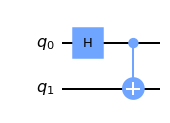

In [7]:
from qiskit.circuit import QuantumCircuit
from qiskit.opflow import Z, X

H = X ^ X

U = QuantumCircuit(2)
U.h(0)
U.cx(0, 1)
U.draw('mpl')

In [8]:
expectation = StateFn(H, is_measurement = True) @ StateFn(U)
matmult_result = expectation.eval()

In [9]:
from qc_grader import grade_lab4_ex1

# Note that the grading function is expecting a complex number
grade_lab4_ex1(matmult_result)

Submitting your answer for lab4/ex1. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.


_Exercise 2: Evaluate the expectation value with the QASM simulator by using the ``QuantumInstance`` object ``q_instance`` defined in the beginning of the notebook._

In [10]:
### Select Backend ###
backend = Aer.get_backend('qasm_simulator')

### Instance - 8192 Shots ###
q_instance = QuantumInstance(backend, shots = 8192, seed_simulator = 2718, seed_transpiler = 2718)

In [11]:
from qiskit.opflow import CircuitSampler, PauliExpectation

sampler = CircuitSampler(q_instance)

In [12]:
### Expectation ###
expectation = StateFn(H, is_measurement=True) @ StateFn(U)
### Simulator ###
in_pauli_basis = PauliExpectation().convert(expectation)
### Obtain result ###
result = sampler.convert(in_pauli_basis).eval()
### Grader Variable ###
shots_result = result

In [13]:
from qc_grader import grade_lab4_ex2

# Note that the grading function is expecting a complex number
grade_lab4_ex2(shots_result)

Submitting your answer for lab4/ex2. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.


### Finite difference gradients

Arguably the simplest way to approximate gradients is with a finite difference scheme. This works independent of the function's inner, possibly very complex, structure.

![](https://i.imgur.com/PcBTYcy.png)

In [14]:
from qiskit.opflow import PauliExpectation, CircuitSampler

### Expectation using qiskit.opflow ###
expectation = StateFn(hamiltonian, is_measurement=True) @ StateFn(ansatz)
### Expectation Converter ###
in_pauli_basis = PauliExpectation().convert(expectation)
### Using a simulator to evaluate ###
sampler = CircuitSampler(q_instance)

In [15]:
def evaluate_expectation(x):
    ### Make a dictionary with ansatz parameters ###
    # The zip() function takes iterables (can be zero or more), aggregates them in a tuple, and return it.
    # with iterable x
    value_dict = dict(zip(ansatz.parameters, x))
    
    ### Obtain Result with value_dict as parameters ###
    result = sampler.convert(in_pauli_basis, params=value_dict).eval()  
    ### Return result ###
    return np.real(result)

In [16]:
### Epsilon value ###
eps = 0.2

### Identity vector with a 1 at index ``index``, otherwise 0 ###
e_i = np.identity(point.size)[:, index]  

### Part of the previous equation ###
plus = point + eps * e_i
minus = point - eps * e_i

In [17]:
finite_difference = (evaluate_expectation(plus) - evaluate_expectation(minus)) / (2 * eps)

print(finite_difference)

-0.002441406250000555


Instead of doing this manually, you can use Qiskit's ``Gradient`` class for this.

In [18]:
from qiskit.opflow import Gradient

### Expectation ###
expectation = StateFn(hamiltonian, is_measurement=True) @ StateFn(ansatz)

### Gradient class with finite differenciation ###
shifter = Gradient('fin_diff', analytic=False, epsilon=eps)

### Concert using Gradient ###
grad = shifter.convert(expectation, params=ansatz.parameters[index])
print(grad)

SummedOp([
  2.5 * ComposedOp([
    OperatorMeasurement(ZZ),
    CircuitStateFn(
         ┌──────────┐     ┌────────────────┐
    q_0: ┤ RY(θ[0]) ├──■──┤ RY(θ[2] + 0.2) ├
         ├──────────┤┌─┴─┐└──┬──────────┬──┘
    q_1: ┤ RY(θ[1]) ├┤ X ├───┤ RY(θ[3]) ├───
         └──────────┘└───┘   └──────────┘   
    )
  ]),
  -2.5 * ComposedOp([
    OperatorMeasurement(ZZ),
    CircuitStateFn(
         ┌──────────┐     ┌────────────────┐
    q_0: ┤ RY(θ[0]) ├──■──┤ RY(θ[2] - 0.2) ├
         ├──────────┤┌─┴─┐└──┬──────────┬──┘
    q_1: ┤ RY(θ[1]) ├┤ X ├───┤ RY(θ[3]) ├───
         └──────────┘└───┘   └──────────┘   
    )
  ])
])


In [19]:
### Dictionary with ansats parameters ###
value_dict = dict(zip(ansatz.parameters, point))

### Convert and Evalueate ### 
sampler.convert(grad, value_dict).eval().real

-0.0213623046875

Finite difference gradients can be volatile on noisy functions and using the exact formula for the gradient can be more stable.

![](https://i.imgur.com/pvssDEQ.png)

### Analytic gradients

Luckily there's a the _parameter shift_ rule -- a simple formula for circuit-based gradients. (**Note:** here only stated for Pauli-rotations without coefficients, see [Evaluating analytic gradients on quantum hardware](https://arxiv.org/abs/1811.11184))

![image.png](https://i.imgur.com/PfkjfOJ.png)

In [20]:
### pi / 2 factor ###
eps = np.pi / 2
### identity vector with a 1 at index ``index``, otherwise 0 ###
e_i = np.identity(point.size)[:, index] 

### Gradient parts ###
plus = point + eps * e_i
minus = point - eps * e_i

### Finite difference with parameter shift rule ###
finite_difference = (evaluate_expectation(plus) - evaluate_expectation(minus)) / 2

print(finite_difference)

0.007568359374999972


In [21]:
### Expectation ###
expectation = StateFn(hamiltonian, is_measurement=True) @ StateFn(ansatz)

### Gradient Class ###
shifter = Gradient()  # parameter-shift rule is the default

### Gradient convert expectation with Ansatz parameters ###
grad = shifter.convert(expectation, params=ansatz.parameters[index])

### Convert grad and Dic, and Evaluate on real values ###
sampler.convert(grad, value_dict).eval().real

0.0013427734374999445

Based on the same principle, there's the _linear combination of unitaries_ approach, that uses only one circuit but an additional auxiliary qubit.

In [22]:
### Linear Combination of Unitaries ###

### Expectation ###
expectation = StateFn(hamiltonian, is_measurement=True) @ StateFn(ansatz)

### Gradiend Class - Linear Combination ###
shifter = Gradient('lin_comb')  # parameter-shift rule is the default

### Grad cpmvert expectation with Ansatz parameters ###
grad = shifter.convert(expectation, params=ansatz.parameters[index])

### Convert grad and values Dict then, evaluate on real values ###
sampler.convert(grad, value_dict).eval().real

-0.005859375

Let's try optimizing!

We fixed an initial point for reproducibility.

In [23]:
# initial_point = np.random.random(ansatz.num_parameters)

### Choose an initial point ###
initial_point = np.array([0.43253681, 0.09507794, 0.42805949, 0.34210341])

Similar to how we have a function to evaluate the expectation value, we'll need a function to evaluate the gradient.

In [24]:
### Expectaton ###
expectation = StateFn(hamiltonian, is_measurement=True).compose(StateFn(ansatz))  

### Gradient class to expectation ###
gradient = Gradient().convert(expectation)

### Transform into pauli basis ###
gradient_in_pauli_basis = PauliExpectation().convert(gradient)

### Simulate ###
sampler = CircuitSampler(q_instance)  

In [25]:
def evaluate_gradient(x):
    value_dict = dict(zip(ansatz.parameters, x))
    result = sampler.convert(gradient_in_pauli_basis, params=value_dict).eval()  # add parameters in here!
    return np.real(result)  

To compare the convergence of the optimizers, we can keep track of the loss at each step by using a callback function.

![image.png](https://i.imgur.com/MGIh0pj.png)

In [26]:
# Note: The GradientDescent class will be released with Qiskit 0.28.0 and can then be imported as:
# from qiskit.algorithms.optimizers import GradientDescent
from qc_grader.gradient_descent import GradientDescent

### Gradient loss callback ###
gd_loss = []

In [27]:
def gd_callback(nfevs, x, fx, stepsize):
    gd_loss.append(fx)

In [28]:
### Gradient Descent ###
gd = GradientDescent(maxiter=300, learning_rate=0.01, callback=gd_callback)

And now we start the optimization and plot the loss!

In [29]:
x_opt, fx_opt, nfevs = gd.optimize(initial_point.size,    # number of parameters
                                   evaluate_expectation,  # function to minimize
                                   gradient_function=evaluate_gradient,  # function to evaluate the gradient
                                   initial_point=initial_point)  # initial point

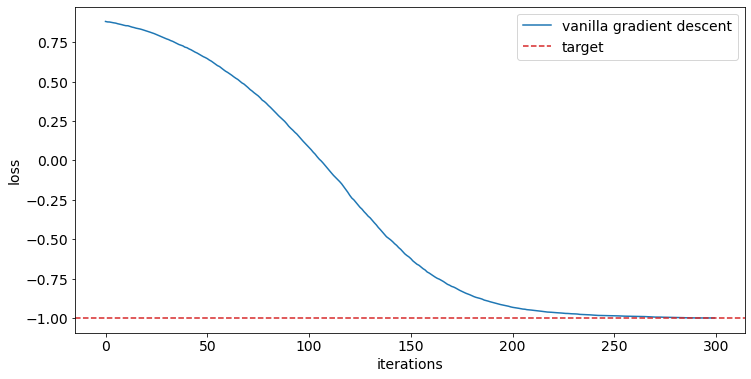

In [30]:
import matplotlib 
import matplotlib.pyplot as plt

matplotlib.rcParams['font.size'] = 14

plt.figure(figsize=(12, 6))

plt.plot(gd_loss, label='vanilla gradient descent')

plt.axhline(-1, ls='--', c='tab:red', label='target')

plt.ylabel('loss')
plt.xlabel('iterations')
plt.legend();

### Does this always work?

![image.png](https://i.imgur.com/mwVuL2M.png)

### Natural gradients

![image-2.png](https://i.imgur.com/kLMkptO.png)

![image.png](https://i.imgur.com/enh7GYi.png)

[Quantum Natural Gradient](https://arxiv.org/abs/1909.02108)

![image.png](https://i.imgur.com/Tiajr2G.png)

With Qiskit, we can evaluate the natural gradient by using the ``NaturalGradient`` class instead of the ``Gradient``!

In [31]:
from qiskit.opflow import NaturalGradient

Analogously to the function to compute gradients, we can now write a function to evaluate the natural gradients.

In [32]:
expectation = StateFn(hamiltonian, is_measurement=True).compose(StateFn(ansatz))  

natural_gradient = NaturalGradient(regularization='ridge').convert(expectation)

natural_gradient_in_pauli_basis = PauliExpectation().convert(natural_gradient)

sampler = CircuitSampler(q_instance, caching="all")   

In [33]:
def evaluate_natural_gradient(x):
    value_dict = dict(zip(ansatz.parameters, x))
    result = sampler.convert(natural_gradient, params=value_dict).eval()  
    return np.real(result) 

And as you can see they do indeed differ!

In [34]:
print('Vanilla gradient:', evaluate_gradient(initial_point))
print('Natural gradient:', evaluate_natural_gradient(initial_point))

Vanilla gradient: [ 0.13989258 -0.35095215 -0.25402832 -0.22497559]
Natural gradient: [ 0.71587182 -0.86457185 -0.98086271 -0.33820243]


Let's look at how this influences the convergence.

In [35]:
qng_loss = []
def qng_callback(nfevs, x, fx, stepsize):
    qng_loss.append(fx)
    
qng = GradientDescent(maxiter=300, learning_rate=0.01, callback=qng_callback)

In [36]:
x_opt, fx_opt, nfevs = qng.optimize(initial_point.size, 
                                    evaluate_expectation, 
                                    gradient_function=evaluate_natural_gradient,
                                    initial_point=initial_point)

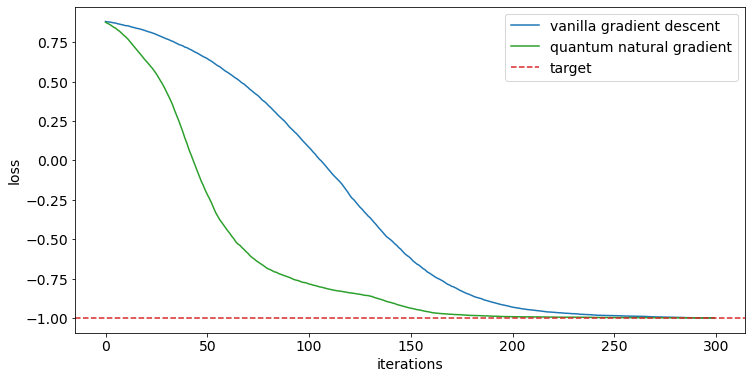

In [37]:
def plot_loss():
    plt.figure(figsize=(12, 6))
    plt.plot(gd_loss, 'tab:blue', label='vanilla gradient descent')
    plt.plot(qng_loss, 'tab:green', label='quantum natural gradient')
    plt.axhline(-1, c='tab:red', ls='--', label='target')
    plt.ylabel('loss')
    plt.xlabel('iterations')
    plt.legend()
    
plot_loss()

This sounds great! But if we think about how many circuits we need to evaluate these gradients can become costly!

![image.png](https://i.imgur.com/eESHpJJ.png)

### Simultaneous Perturbation Stochastic Approximation

Idea: avoid the expensive gradient evaluation by sampling from the gradients. Since we don't care about the exact values but only about convergence, an unbiased sampling should on average work equally well!

![image.png](https://i.imgur.com/huDuGSP.png)

This optimization technique is known as SPSA. How does it perform?

In [38]:
from qc_grader.spsa import SPSA

spsa_loss = []
def spsa_callback(nfev, x, fx, stepsize, accepted):
    spsa_loss.append(fx)

spsa = SPSA(maxiter=300, learning_rate=0.01, perturbation=0.01, callback=spsa_callback)

x_opt, fx_opt, nfevs = spsa.optimize(initial_point.size, 
                                     evaluate_expectation, 
                                     initial_point=initial_point)

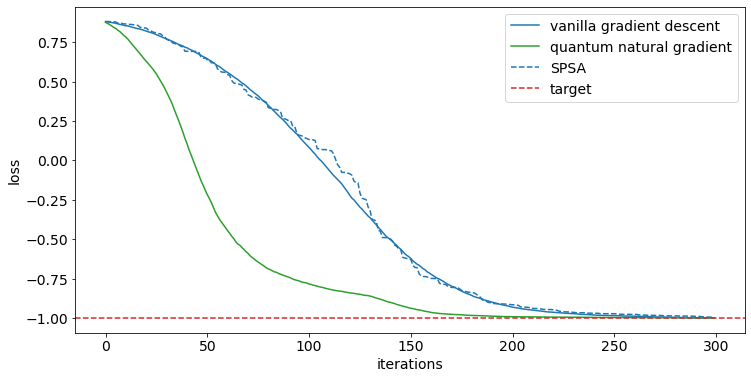

In [39]:
def plot_loss():
    plt.figure(figsize=(12, 6))
    plt.plot(gd_loss, 'tab:blue', label='vanilla gradient descent')
    plt.plot(qng_loss, 'tab:green', label='quantum natural gradient')
    plt.plot(spsa_loss, 'tab:blue', ls='--', label='SPSA')
    plt.axhline(-1, c='tab:red', ls='--', label='target')
    plt.ylabel('loss')
    plt.xlabel('iterations')
    plt.legend()
    
plot_loss()

And just at a fraction of the cost!

Can we do the same for natural gradients? 

![image.png](https://i.imgur.com/ttZm7xg.png)

![image.png](https://i.imgur.com/DP88wLN.png)

[Simultaneous Perturbation Stochastic Approximation of the Quantum Fisher Information](https://arxiv.org/abs/2103.09232)

It turns out -- yes, we can!

We'll skip the details here, but the idea is to sample not only from the gradient but to extend this to the quantum Fisher information and thus to the natural gradient.

In [40]:
# Note: The QNSPSA class will be released with Qiskit 0.28.0 and can then be imported as:
# from qiskit.algorithms.optimizers import QNSPSA
from qc_grader.qnspsa import QNSPSA

qnspsa_loss = []
def qnspsa_callback(nfev, x, fx, stepsize, accepted):
    qnspsa_loss.append(fx)

fidelity = QNSPSA.get_fidelity(ansatz, q_instance, expectation=PauliExpectation())
qnspsa = QNSPSA(fidelity, maxiter=300, learning_rate=0.01, perturbation=0.01, callback=qnspsa_callback)

x_opt, fx_opt, nfevs = qnspsa.optimize(initial_point.size, 
                                       evaluate_expectation, 
                                       initial_point=initial_point)

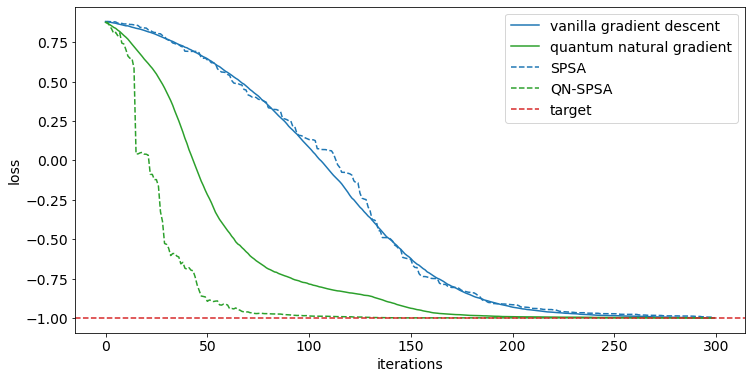

In [41]:
def plot_loss():
    plt.figure(figsize=(12, 6))
    plt.plot(gd_loss, 'tab:blue', label='vanilla gradient descent')
    plt.plot(qng_loss, 'tab:green', label='quantum natural gradient')
    plt.plot(spsa_loss, 'tab:blue', ls='--', label='SPSA')
    plt.plot(qnspsa_loss, 'tab:green', ls='--', label='QN-SPSA')
    plt.axhline(-1, c='tab:red', ls='--', label='target')
    plt.ylabel('loss')
    plt.xlabel('iterations')
    plt.legend()
    
plot_loss()

What are the costs? 

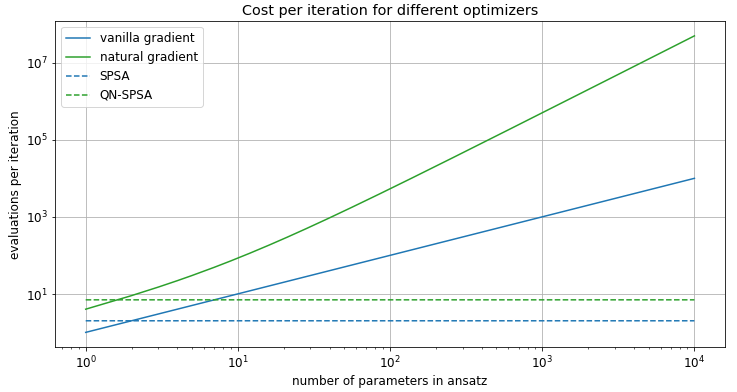

## Training in practice


Today, evaluating gradients is really expensive and the improved accuracy is not that valuable since we have noisy readout anyways. Therefore, in practice, people often resort to using SPSA. To improve convergence, we do however not use a constant learning rate, but an exponentially decreasing one.

![](https://i.imgur.com/36BZ3Ar.png)

Qiskit will try to automatically calibrate the learning rate to the model if you don't specify the learning rate.

In [42]:
autospsa_loss = []
def autospsa_callback(nfev, x, fx, stepsize, accepted):
    autospsa_loss.append(fx)

autospsa = SPSA(maxiter=300, learning_rate=None, perturbation=None, callback=autospsa_callback)

x_opt, fx_opt, nfevs = autospsa.optimize(initial_point.size, 
                                         evaluate_expectation, 
                                         initial_point=initial_point)

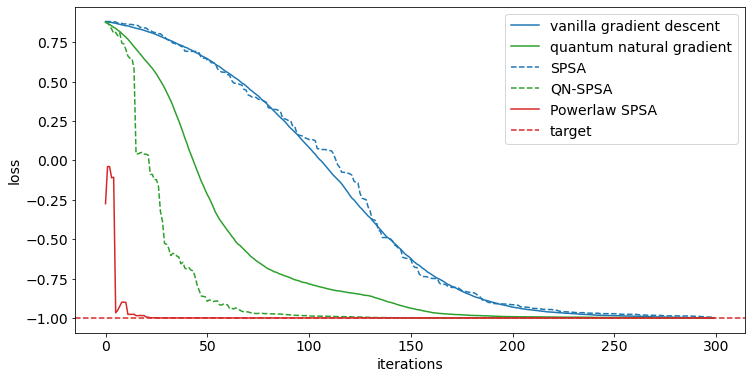

In [43]:
def plot_loss():
    plt.figure(figsize=(12, 6))
    plt.plot(gd_loss, 'tab:blue', label='vanilla gradient descent')
    plt.plot(qng_loss, 'tab:green', label='quantum natural gradient')
    plt.plot(spsa_loss, 'tab:blue', ls='--', label='SPSA')
    plt.plot(qnspsa_loss, 'tab:green', ls='--', label='QN-SPSA')
    plt.plot(autospsa_loss, 'tab:red', label='Powerlaw SPSA')
    plt.axhline(-1, c='tab:red', ls='--', label='target')
    plt.ylabel('loss')
    plt.xlabel('iterations')
    plt.legend()
    
plot_loss()

**_Training a new loss function._**

_In this exercise we'll train a different loss function than before: A transverse field Ising Hamiltonian on a linear chain with 3 spins_

$$
    \hat H = -Z_0 Z_1 - Z_1 Z_2 - X_0 - X_1 - X_2
$$
_or, spelling out all operations_
$$
    \hat H = -Z \otimes Z \otimes I - I \otimes Z \otimes Z - X \otimes I \otimes I - I \otimes X \otimes I - I \otimes I \otimes X.
$$

_Exercise 3: Define the Hamiltonian with Opflow's operators. Make sure to add brackets around the tensors, e.g. ``(X ^ X) + (Z ^ I)`` for $X \otimes X + Z \otimes I$._

In [44]:
H_tfi = -(Z ^ Z ^ I) - (I ^ Z ^ Z) - (X ^ I ^ I) - (I ^ X ^ I) - (I ^ I ^ X)

In [45]:
from qc_grader import grade_lab4_ex3

# Note that the grading function is expecting a Hamiltonian
grade_lab4_ex3(H_tfi)

Submitting your answer for lab4/ex3. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.


_Exercise 4: We'll use the ``EfficientSU2`` variational form as ansatz, since now we care about complex amplitudes. Use the ``evaluate_tfi`` function, which evaluates the energy of the transverse-field Ising Hamiltonian, to find the optimal parameters with ``SPSA``._

In [46]:
from qiskit.circuit.library import EfficientSU2

efficient_su2 = EfficientSU2(3, entanglement="linear", reps=2)
tfi_sampler = CircuitSampler(q_instance)  

In [47]:
def evaluate_tfi(parameters):
    exp = StateFn(H_tfi, is_measurement=True).compose(StateFn(efficient_su2))  
    value_dict = dict(zip(efficient_su2.parameters, parameters))
    result = tfi_sampler.convert(PauliExpectation().convert(exp), params=value_dict).eval()  
    return np.real(result) 

_In this cell, use the SPSA optimizer to find the minimum._

_Hint: Use the autocalibration (by not specifying the learning rate and perturbation) and 300 iterations to get close enough to the minimum._

In [48]:
# target energy
tfi_target = -3.4939592074349326

# initial point for reproducibility
tfi_init = np.array([0.95667807, 0.06192812, 0.47615196, 0.83809827, 0.89022282,
                     0.27140831, 0.9540853 , 0.41374024, 0.92595507, 0.76150126,
                     0.8701938 , 0.05096063, 0.25476016, 0.71807858, 0.85661325,
                     0.48311132, 0.43623886, 0.6371297 ])


# TODO optimize with SPSA (300 iterations with automatic calibration should be fine)
from qc_grader.spsa import SPSA

spsa_loss = []
def spsa_callback(nfev, x, fx, stepsize, accepted):
    spsa_loss.append(fx)

spsa = SPSA(maxiter=300, learning_rate=None, perturbation=None)

tfi_result = spsa.optimize(tfi_init.size,
                           evaluate_tfi, 
                           initial_point=tfi_init)
 

tfi_minimum = tfi_result[1]

In [49]:
tfi_minimum

-3.4296875

In [50]:
print("Error:", np.abs(tfi_result[1] - tfi_target))

Error: 0.0642717074349326


In [51]:
from qc_grader import grade_lab4_ex4

# Note that the grading function is expecting a floating point number
grade_lab4_ex4(tfi_minimum)

Submitting your answer for lab4/ex4. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.


## How can you use it in VQC/QNNs? 

![](https://i.imgur.com/aPduaO7.png)

### Generating data

We're using some artificial dataset provided by Qiskit's ML package. There are other datasets available, like Iris or Wine, but we'll keep it simple and 2D so we can plot the data.

In [52]:
from qiskit_machine_learning.datasets import ad_hoc_data

training_features, training_labels, test_features, test_labels = ad_hoc_data(
    training_size=20, test_size=10, n=2, one_hot=False, gap=0.5
)

# the training labels are in {0, 1} but we'll use {-1, 1} as class labels!
training_labels = 2 * training_labels - 1
test_labels = 2 * test_labels - 1

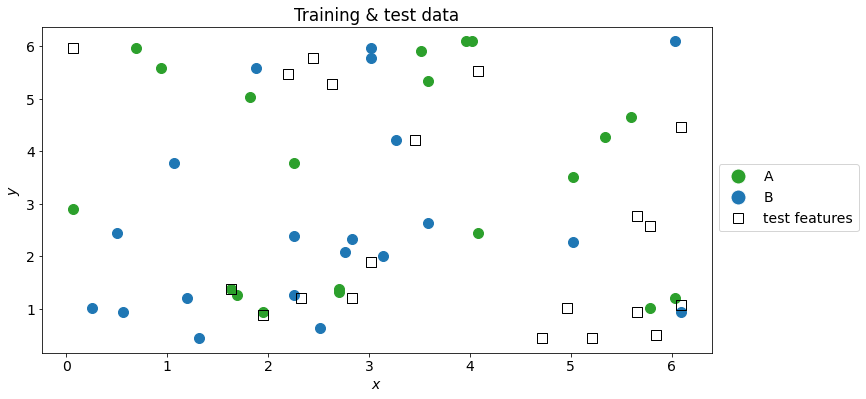

In [33]:
def plot_sampled_data():
    from matplotlib.patches import Patch
    from matplotlib.lines import Line2D
    import matplotlib.pyplot as plt

    plt.figure(figsize=(12,6))

    for feature, label in zip(training_features, training_labels):
        marker = 'o' 
        color = 'tab:green' if label == -1 else 'tab:blue'
        plt.scatter(feature[0], feature[1], marker=marker, s=100, color=color)
    
    for feature, label in zip(test_features, test_labels):
        marker = 's' 
        plt.scatter(feature[0], feature[1], marker=marker, s=100, facecolor='none', edgecolor='k')
    
    legend_elements = [
        Line2D([0], [0], marker='o', c='w', mfc='tab:green', label='A', ms=15),
        Line2D([0], [0], marker='o', c='w', mfc='tab:blue', label='B', ms=15),
        Line2D([0], [0], marker='s', c='w', mfc='none', mec='k', label='test features', ms=10)
    ]

    plt.legend(handles=legend_elements, bbox_to_anchor=(1, 0.6))
    
    plt.title('Training & test data')
    plt.xlabel('$x$')
    plt.ylabel('$y$')
    
plot_sampled_data()

### Building a variational quantum classifier

Let's get the constituents we need:

* a Feature Map to encode the data
* an Ansatz to train
* an Observable to evaluate


We'll use a standard feature map from the circuit library.

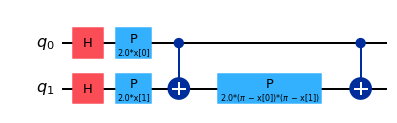

In [34]:
from qiskit.circuit.library import ZZFeatureMap

dim = 2
feature_map = ZZFeatureMap(dim, reps=1)  # let's keep it simple!
feature_map.draw('mpl', style='iqx')

We don't care about complex amplitudes so let's use an ansatz with only real amplitudes.

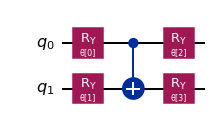

In [35]:
ansatz = RealAmplitudes(num_qubits=dim, entanglement='linear', reps=1)  # also simple here!
ansatz.draw('mpl', style='iqx')

Put together our circuit is

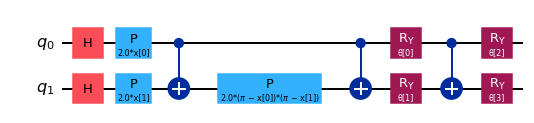

In [36]:
circuit = feature_map.compose(ansatz)
circuit.draw('mpl', style='iqx')

And we'll use global $\bigotimes_{i} \hat Z_i$ operators for the expectation values.

In [37]:
hamiltonian = Z ^ Z  # global Z operators

## Classifying our data

Now we understood all the parts, it's time to classify the data. We're using Qiskit's ML package for that and it's ``OpflowQNN`` class to describe the circuit and expectation value along with a ``NeuralNetworkClassifier`` for the training.

First, we'll do vanilla gradient descent.

In [38]:
gd_qnn_loss = []
def gd_qnn_callback(*args):
    gd_qnn_loss.append(args[2])
    
gd = GradientDescent(maxiter=100, learning_rate=0.01, callback=gd_qnn_callback)

In [39]:
from qiskit_machine_learning.neural_networks import OpflowQNN

qnn_expectation = StateFn(hamiltonian, is_measurement=True) @ StateFn(circuit)

qnn = OpflowQNN(qnn_expectation, 
                input_params=list(feature_map.parameters), 
                weight_params=list(ansatz.parameters),
                exp_val=PauliExpectation(),
                gradient=Gradient(),  # <-- Parameter-Shift gradients
                quantum_instance=q_instance)

Now we can define the classifier, which takes the QNN, the loss and the optimizer.

In [40]:
from qiskit_machine_learning.algorithms import NeuralNetworkClassifier
#initial_point = np.array([0.2, 0.1, 0.3, 0.4])
classifier = NeuralNetworkClassifier(qnn, optimizer=gd)

... and train!

In [41]:
classifier.fit(training_features, training_labels);

To predict the new labels for the test features we can use the ``predict`` method.

In [42]:
predicted = classifier.predict(test_features)

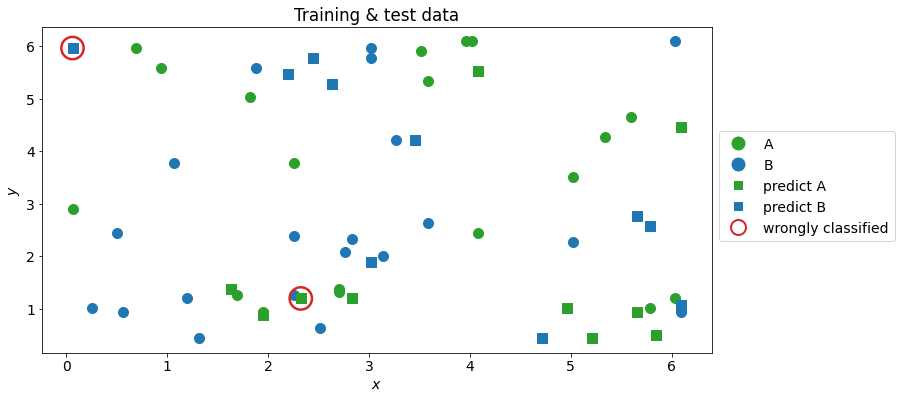

In [43]:
def plot_predicted():
    from matplotlib.lines import Line2D
    plt.figure(figsize=(12, 6))

    for feature, label in zip(training_features, training_labels):
        marker = 'o' 
        color = 'tab:green' if label == -1 else 'tab:blue'
        plt.scatter(feature[0], feature[1], marker=marker, s=100, color=color)
    
    for feature, label, pred in zip(test_features, test_labels, predicted):
        marker = 's' 
        color = 'tab:green' if pred == -1 else 'tab:blue'
        if label != pred:  # mark wrongly classified
            plt.scatter(feature[0], feature[1], marker='o', s=500, linewidths=2.5,
                        facecolor='none', edgecolor='tab:red')

        plt.scatter(feature[0], feature[1], marker=marker, s=100, color=color)
    
    legend_elements = [
        Line2D([0], [0], marker='o', c='w', mfc='tab:green', label='A', ms=15),
        Line2D([0], [0], marker='o', c='w', mfc='tab:blue', label='B', ms=15),
        Line2D([0], [0], marker='s', c='w', mfc='tab:green', label='predict A', ms=10),
        Line2D([0], [0], marker='s', c='w', mfc='tab:blue', label='predict B', ms=10),
        Line2D([0], [0], marker='o', c='w', mfc='none', mec='tab:red', label='wrongly classified', mew=2, ms=15)
    ]

    plt.legend(handles=legend_elements, bbox_to_anchor=(1, 0.7))
    
    plt.title('Training & test data')
    plt.xlabel('$x$')
    plt.ylabel('$y$')
    
plot_predicted()

And since we know how to use the natural gradients, we can now train with the QNN with natural gradient descent by replacing ``Gradient`` with ``NaturalGradient``.

In [44]:
qng_qnn_loss = []
def qng_qnn_callback(*args):
    qng_qnn_loss.append(args[2])
    
gd = GradientDescent(maxiter=100, learning_rate=0.01, callback=qng_qnn_callback)

In [45]:
qnn = OpflowQNN(qnn_expectation, 
                input_params=list(feature_map.parameters), 
                weight_params=list(ansatz.parameters),
                gradient=NaturalGradient(regularization='ridge'),  # <-- using Natural Gradients!
                quantum_instance=q_instance)
classifier = NeuralNetworkClassifier(qnn, optimizer=gd)#, initial_point=initial_point)

In [46]:
classifier.fit(training_features, training_labels);

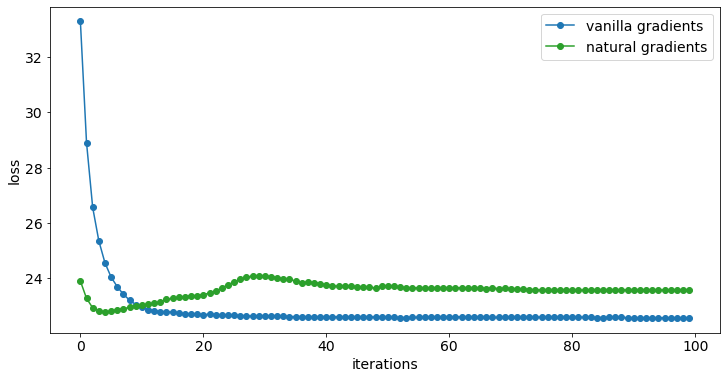

In [47]:
def plot_losses():

    plt.figure(figsize=(12, 6))
    plt.plot(gd_qnn_loss, 'tab:blue', marker='o', label='vanilla gradients')
    plt.plot(qng_qnn_loss, 'tab:green', marker='o', label='natural gradients')
    plt.xlabel('iterations')
    plt.ylabel('loss')
    plt.legend(loc='best')

plot_losses()

## Limits in training circuits

Nothing in life is for free... that includes sufficiently large gradients for all models!

We've seen that training with gradients works well on the small models we tested. But can we expect the same if we increase the number of qubits? To investigate that we measure the variance of the gradients for different model sizes. The idea is simple: if the variance is really small, we don't have enough information to update our parameters.

### Exponentially vanishing gradients (Barren plateaus)

[Barren plateaus in quantum neural network training landscapes](https://arxiv.org/abs/1803.11173)

[Cost Function Dependent Barren Plateaus in Shallow Parametrized Quantum Circuits](http://arxiv-export-lb.library.cornell.edu/pdf/2001.00550)

Let's pick our favorite example from the gradients and see what happens if we increase the number of qubits and layers.

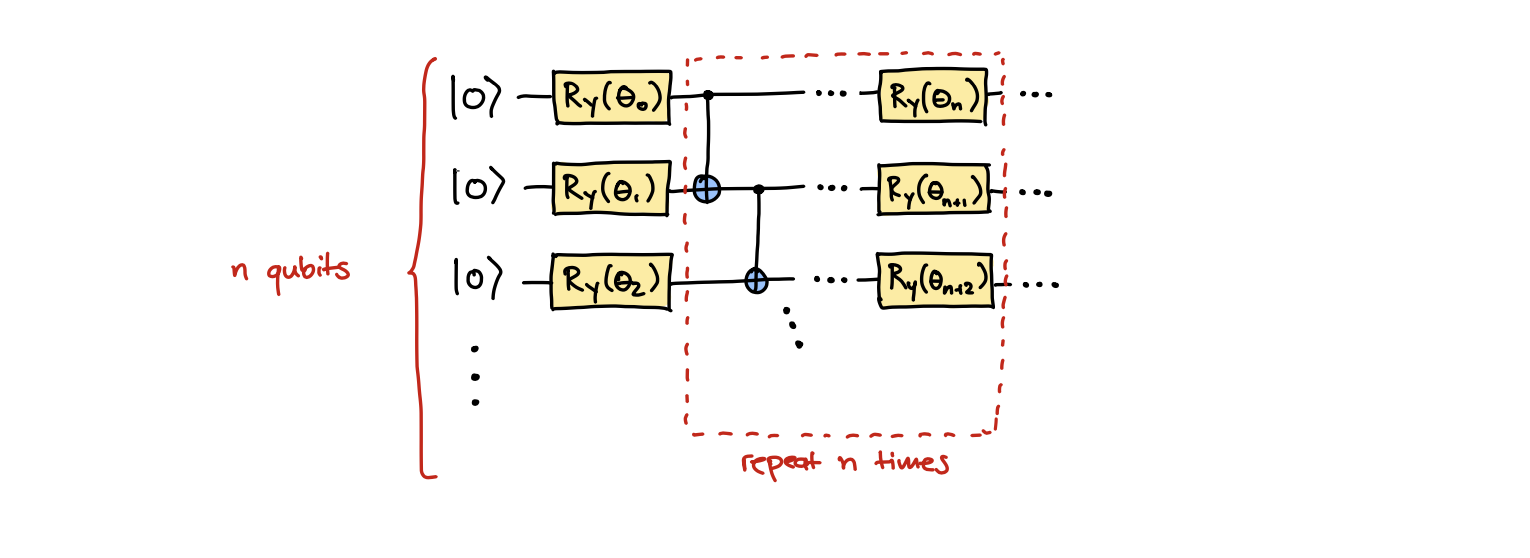

In [48]:
from qiskit.opflow import I

def sample_gradients(num_qubits, reps, local=False):
    """Sample the gradient of our model for ``num_qubits`` qubits and ``reps`` repetitions.
    
    We sample 100 times for random parameters and compute the gradient of the first RY rotation gate.
    """
    index = num_qubits - 1

    # you can also exchange this for a local operator and observe the same!
    if local:
        operator = Z ^ Z ^ (I ^ (num_qubits - 2))
    else:
        operator = Z ^ num_qubits
    
    # real amplitudes ansatz
    ansatz = RealAmplitudes(num_qubits, entanglement='linear', reps=reps)

    # construct Gradient we want to evaluate for different values
    expectation = StateFn(operator, is_measurement=True).compose(StateFn(ansatz))
    grad = Gradient().convert(expectation, params=ansatz.parameters[index])
    
    # evaluate for 100 different, random parameter values
    num_points = 100
    grads = []
    for _ in range(num_points):
        # points are uniformly chosen from [0, pi]
        point = np.random.uniform(0, np.pi, ansatz.num_parameters)
        value_dict = dict(zip(ansatz.parameters, point))
        grads.append(sampler.convert(grad, value_dict).eval())
        
    return grads

Let's plot from 2 to 12 qubits.

In [49]:
num_qubits = list(range(2, 13))
reps = num_qubits  # number of layers = numbers of qubits
gradients = [sample_gradients(n, r) for n, r in zip(num_qubits, reps)]  

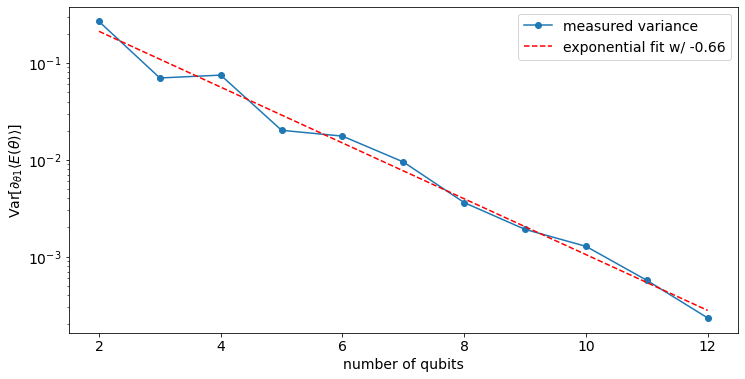

In [51]:
fit = np.polyfit(num_qubits, np.log(np.var(gradients, axis=1)), deg=1)
x = np.linspace(num_qubits[0], num_qubits[-1], 200)

plt.figure(figsize=(12, 6))
plt.semilogy(num_qubits, np.var(gradients, axis=1), 'o-', label='measured variance')
plt.semilogy(x, np.exp(fit[0] * x + fit[1]), 'r--', label=f'exponential fit w/ {fit[0]:.2f}')
plt.xlabel('number of qubits')
plt.ylabel(r'$\mathrm{Var}[\partial_{\theta 1} \langle E(\theta) \rangle]$')
plt.legend(loc='best');

Oh no! The variance decreases exponentially! This means our gradients contain less and less information and we'll have a hard time to train the model. This is known as the _Barren plateau_ problem or _exponentially vanishing gradients_.

**_Exploratory Exercise: Do Natural Gradient suffer from vanishing gradients?_**

_Repeat the Barren plateau plot for natural gradients instead of standard gradients. For this, write a new function ``sample_natural_gradients`` that computes the natural gradient instead of the gradient._

In [ ]:
from qiskit.opflow import NaturalGradient

def sample_natural_gradients(num_qubits, reps):
    index = num_qubits - 1

    operator = Z ^ num_qubits
    
    ansatz = RealAmplitudes(num_qubits, entanglement='linear', reps=reps)

    expectation = StateFn(operator, is_measurement=True).compose(StateFn(ansatz))
    grad = # TODO: ``grad`` should be the natural gradient for the parameter at index ``index``.
    # Hint: Check the ``sample_gradients`` function, this one is almost the same.
    grad = NaturalGradient().convert(expectation, params=ansatz.parameters[index])
    
    num_points = 100
    grads = []
    for _ in range(num_points):
        point = np.random.uniform(0, np.pi, ansatz.num_parameters)
        value_dict = dict(zip(ansatz.parameters, point))
        grads.append(sampler.convert(grad, value_dict).eval())
    return grads

_Now we'll repeat the experiment to check the variance of the gradients (this cell takes some time to run!)_

In [ ]:
num_qubits = list(range(2, 13))
reps = num_qubits  # number of layers = numbers of qubits
natural_gradients = [sample_natural_gradients(n, r) for n, r in zip(num_qubits, reps)]  

_and plot the results. What do you observe?_

In [ ]:
fit = np.polyfit(num_qubits, np.log(np.var(natural_gradients, axis=1)), deg=1)
x = np.linspace(num_qubits[0], num_qubits[-1], 200)

plt.figure(figsize=(12, 6))
plt.semilogy(num_qubits, np.var(gradients, axis=1), 'o-', label='vanilla gradients')
plt.semilogy(num_qubits, np.var(natural_gradients, axis=1), 's-', label='natural gradients')
plt.semilogy(x, np.exp(fit[0] * x + fit[1]), 'r--', label=f'exponential fit w/ {float(fit[0]):.2f}')
plt.xlabel('number of qubits')
plt.ylabel(r'$\mathrm{Var}[\partial_{\theta 1} \langle E(\theta) \rangle]$')
plt.legend(loc='best');

### What about shorter circuits?

Is there something we can do about these Barren plateaus? It's a hot topic in current research and there are some proposals to mitigate Barren plateaus.

Let's have a look on how global and local cost functions and the depth of the ansatz influences the Barren plateaus.

In [52]:
num_qubits = list(range(2, 13))
fixed_depth_global_gradients = [sample_gradients(n, 1) for n in num_qubits]  

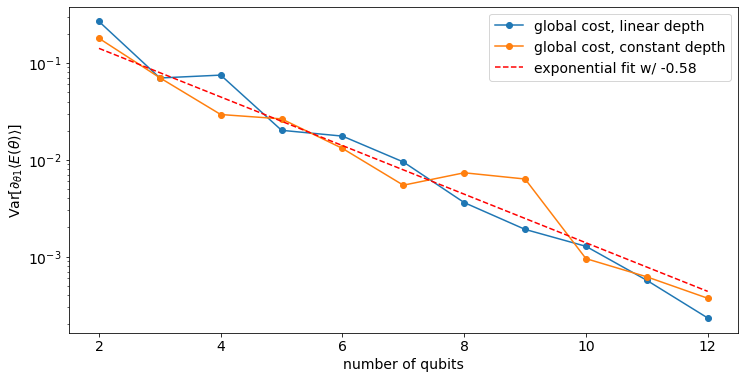

In [53]:
fit = np.polyfit(num_qubits, np.log(np.var(fixed_depth_global_gradients, axis=1)), deg=1)
x = np.linspace(num_qubits[0], num_qubits[-1], 200)

plt.figure(figsize=(12, 6))
plt.semilogy(num_qubits, np.var(gradients, axis=1), 'o-', label='global cost, linear depth')
plt.semilogy(num_qubits, np.var(fixed_depth_global_gradients, axis=1), 'o-', label='global cost, constant depth')
plt.semilogy(x, np.exp(fit[0] * x + fit[1]), 'r--', label=f'exponential fit w/ {fit[0]:.2f}')
plt.xlabel('number of qubits')
plt.ylabel(r'$\mathrm{Var}[\partial_{\theta 1} \langle E(\theta) \rangle]$')
plt.legend(loc='best');

### And what if we use _local_ operators?

In [54]:
num_qubits = list(range(2, 13))
linear_depth_local_gradients = [sample_gradients(n, n, local=True) for n in num_qubits]  

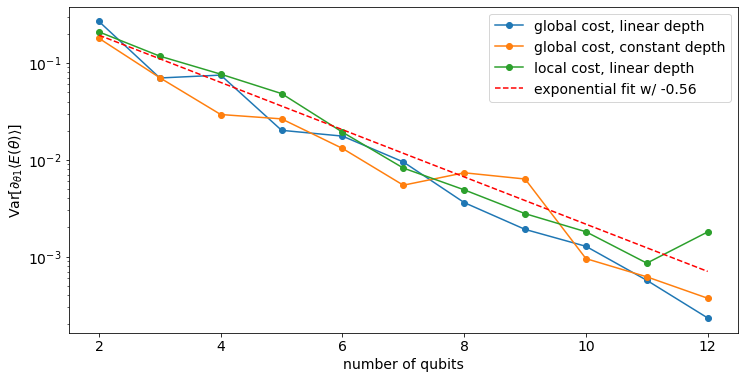

In [55]:
fit = np.polyfit(num_qubits, np.log(np.var(linear_depth_local_gradients, axis=1)), deg=1)
x = np.linspace(num_qubits[0], num_qubits[-1], 200)

plt.figure(figsize=(12, 6))
plt.semilogy(num_qubits, np.var(gradients, axis=1), 'o-', label='global cost, linear depth')
plt.semilogy(num_qubits, np.var(fixed_depth_global_gradients, axis=1), 'o-', label='global cost, constant depth')
plt.semilogy(num_qubits, np.var(linear_depth_local_gradients, axis=1), 'o-', label='local cost, linear depth')
plt.semilogy(x, np.exp(fit[0] * x + fit[1]), 'r--', label=f'exponential fit w/ {fit[0]:.2f}')
plt.xlabel('number of qubits')
plt.ylabel(r'$\mathrm{Var}[\partial_{\theta 1} \langle E(\theta) \rangle]$')
plt.legend(loc='best');

In [56]:
num_qubits = list(range(2, 13))
fixed_depth_local_gradients = [sample_gradients(n, 1, local=True) for n in num_qubits]  

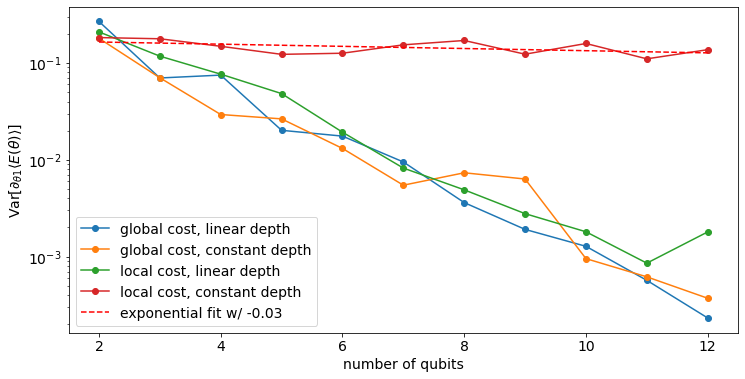

In [57]:
fit = np.polyfit(num_qubits, np.log(np.var(fixed_depth_local_gradients, axis=1)), deg=1)
x = np.linspace(num_qubits[0], num_qubits[-1], 200)

plt.figure(figsize=(12, 6))
plt.semilogy(num_qubits, np.var(gradients, axis=1), 'o-', label='global cost, linear depth')
plt.semilogy(num_qubits, np.var(fixed_depth_global_gradients, axis=1), 'o-', label='global cost, constant depth')
plt.semilogy(num_qubits, np.var(linear_depth_local_gradients, axis=1), 'o-', label='local cost, linear depth')
plt.semilogy(num_qubits, np.var(fixed_depth_local_gradients, axis=1), 'o-', label='local cost, constant depth')
plt.semilogy(x, np.exp(fit[0] * x + fit[1]), 'r--', label=f'exponential fit w/ {fit[0]:.2f}')
plt.xlabel('number of qubits')
plt.ylabel(r'$\mathrm{Var}[\partial_{\theta 1} \langle E(\theta) \rangle]$')
plt.legend(loc='best');

### Layerwise training

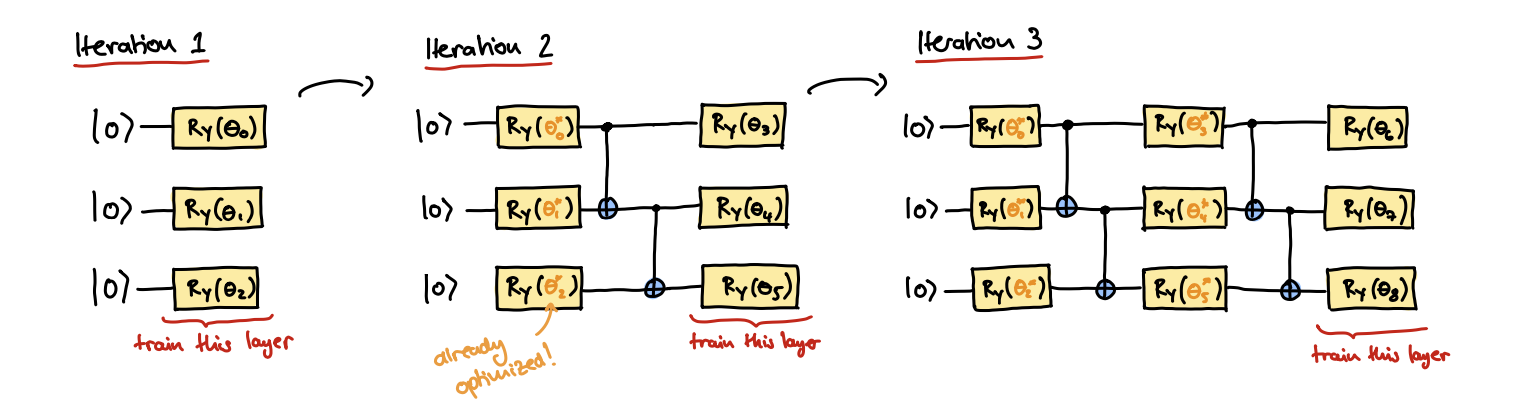

In [58]:
num_qubits = 6
operator = Z ^ Z ^ (I ^ (num_qubits - 4))

def minimize(circuit, optimizer):
    initial_point = np.random.random(circuit.num_parameters)
    
    exp = StateFn(operator, is_measurement=True) @ StateFn(circuit)
    grad = Gradient().convert(exp)
    
    # pauli basis
    exp = PauliExpectation().convert(exp)
    grad = PauliExpectation().convert(grad)

    sampler = CircuitSampler(q_instance, caching="all")
    
    def loss(x):
        values_dict = dict(zip(circuit.parameters, x))
        return np.real(sampler.convert(exp, values_dict).eval())
    
    def gradient(x):
        values_dict = dict(zip(circuit.parameters, x))
        return np.real(sampler.convert(grad, values_dict).eval())

    return optimizer.optimize(circuit.num_parameters, loss, gradient, initial_point=initial_point)

Useful feature: Qiskit's ansatz circuits are mutable!

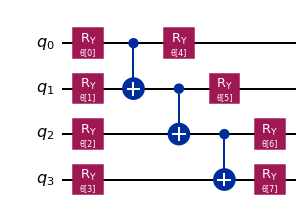

In [59]:
circuit = RealAmplitudes(4, reps=1, entanglement='linear')
circuit.draw('mpl', style='iqx')

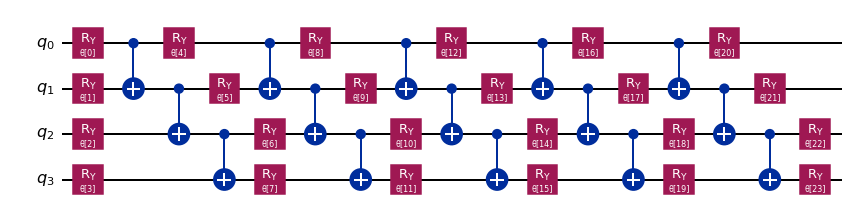

In [60]:
circuit.reps = 5
circuit.draw('mpl', style='iqx')

In [64]:
def layerwise_training(ansatz, max_num_layers, optimizer):
    optimal_parameters = []
    fopt = None
    for reps in range(1, max_num_layers):
        ansatz.reps = reps
        
        # bind already optimized parameters
        values_dict = dict(zip(ansatz.parameters, optimal_parameters))
        partially_bound = ansatz.bind_parameters(values_dict)
        
        xopt, fopt, _ = minimize(partially_bound, optimizer)
        print('Circuit depth:', ansatz.depth(), 'best value:', fopt)
        optimal_parameters += list(xopt)
    
    return fopt, optimal_parameters

In [65]:
ansatz = RealAmplitudes(4, entanglement='linear')
optimizer = GradientDescent(maxiter=50)

In [66]:
np.random.seed(12)
fopt, optimal_parameters = layerwise_training(ansatz, 4, optimizer)

Circuit depth: 5 best value: 0.2421875
Circuit depth: 8 best value: -0.14428710937499992
Circuit depth: 11 best value: -0.513427734375


## Summary

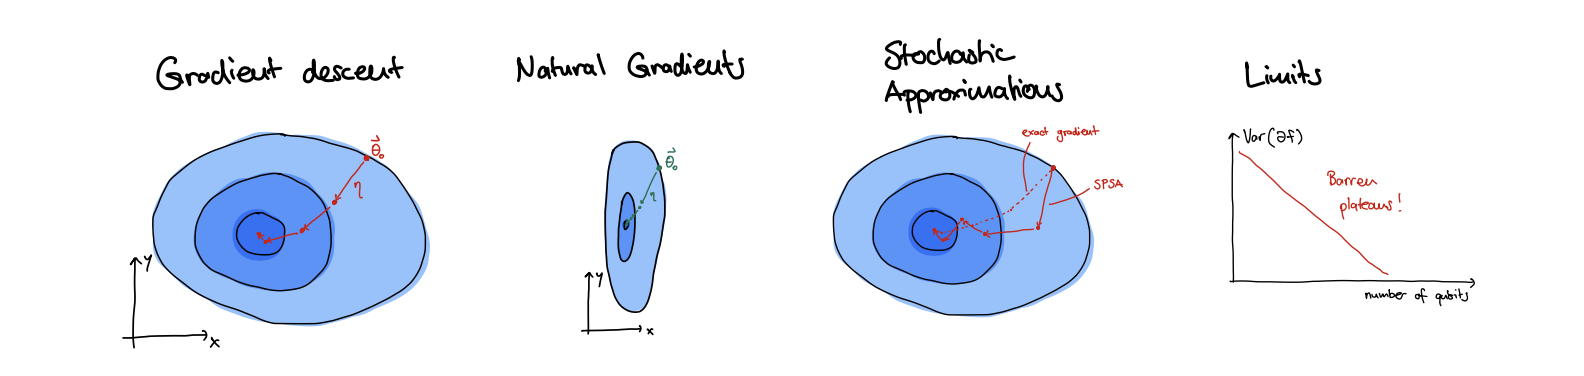